# Time Series Analysis

## Overview

Time series analysis deals with ordered sequences of data, e.g., data over time. Consider the following example.

<img src="images/timeseries_general.png" alt="Example for Classification" style="width: 600px;"/>

The foundation of the time series analysis are passenger numbers measured every month. Thus, we have an instance for every month in the data. The goal of the time series analysis is to describe the temporal structure of the data, i.e., to find a model that explains how the data changes from month to month. This could be done, e.g., to predict the next value of a time series. A bit more abstract, time series analysis can be described as follows. 

<img src="images/timeseries_abstract.png" alt="Example for Classification" style="width: 500px;"/>

Our data are values at enumerated points in time. The time series model describes how the data changes over time. This problem is related to regression: if we where to say that the time is our feature and the value at that time is our dependent variable, we would have a very simple time series analysis.

### The Formal Problem

Formally, we have discrete values $\{x_1, .., x_T\} = \{x_t\}_{t=1}^T$ with $x_t \in \mathbb{R}$. Mathematically, these values can be seen as a series of random variables or as a stochastic process. A core assumption of the series analysis is that the difference between the time $t$ and the time $t+1$ is equal for all $t=1, ..., T-1$. Thus, we have a fixed step size for the time, e.g., minutes, hours, days, weeks, months, or years. 

A time series consists of different *components*. We consider three such components: 

- The *trend* of the time series $T_t$. The trend is the overall change over time, e.g., a steady growth or decline in values. An example for the trend is, e.g., the constantly growing energy consumption is most countries.  
- The *seasonality* of the time series $S_t$. The seasonality is the result of *seasonal effects*, i.e., regularly recurring effects that lead to an increase or decrease with respect to the general trend. An example for a seasonal effect is, e.g., the change in energy consumption over the year, because it is longer dark outside. 
- The *autocorrelation* between observations $R_t$. The autocorrelation models how the value at time $t$ depends on the prior values, i.e., how $x_t$ is correlated with $x_{t-i}, x_{t-2}, ...$. This autocorrelation models the changes in the time series that are not explained by the trend or seasonality. 

These three components together define the value of our time series, i.e.,

$$x_t = T_t + S_t + R_t.$$

## Box-Jenkins

We consider a special case of time series models, so called *Box-Jenkins* models. With the Box-Jenkins approach, we first need to ensure that the time series is *stationary* and can then model the autocorrelation as a stochastic process that combines the dependencies on past values with a random component. 

Stationary means that the mean value and the variance are constant and do not change over time. For time series, this means that we must first determine the trend and seasonality of the data. The trend is a model for how the mean value of a time series changes over time, the seasonality models how the mean value of a time series changes during seasons. If both are removed, the remaining autocorrelation should be stationary. Because the autocorrelation is modeled for stationary data, Box-Jenkins models achieve this with only few parameters. 

In the following, we consider each aspect of a Box-Jenkins approach for time series analysis in detail. First, we how the trend and seasonality can be determined and removed from the data. Afterwards, we look at ARMA models for the autocorrelation. 

We explain the time series analysis using a running example, i.e., data about air passengers from 1949 to 1961. The data is measured monthly, i.e., the difference between two time points is one month. 

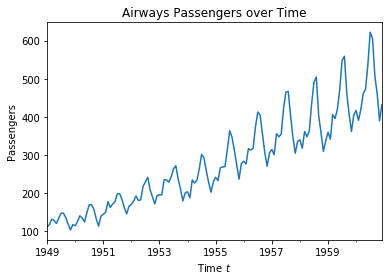

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

air_passengers_df = pd.read_csv("data/AirPassengers.csv", header = 0, parse_dates = [0], names = ['Month', 'Passengers'], index_col = 0, squeeze=True)

plt.figure()
plt.title("Airways Passengers over Time")
air_passengers_df.plot()
plt.xlabel('Time $t$')
plt.ylabel('Passengers')
plt.show()

## Trend and Seasonal Effects

### Regression and Seasonal Means

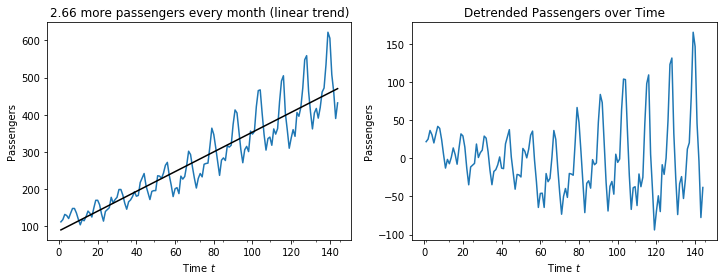

In [21]:
import numpy as np
from sklearn.linear_model import LinearRegression


X = np.arange(1,air_passengers_df.shape[0]+1).reshape(-1,1)
Y = air_passengers_df.values

regr = LinearRegression()
regr.fit(X,Y)
T_pred = regr.predict(X)
air_passengers_detrended = air_passengers_df - T_pred

f, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].set_title('%.2f more passengers every month (linear trend)' % regr.coef_[0])
axes[0].plot(X, Y)
axes[0].plot(X, T_pred, color='black')
axes[0].set_xlabel('Time $t$')
axes[0].set_xticks(np.arange(0,13)*12+1, ('1949','','1951','','1953','','1955','','1957','','1959','','1961'))
axes[0].set_ylabel('Passengers')

axes[1].set_title('Detrended Passengers over Time')
axes[1].plot(X, air_passengers_detrended)
axes[1].set_xlabel('Time $t$')
axes[1].set_xticks(np.arange(0,13)*12+1, ('1949','','1951','','1953','','1955','','1957','','1959','','1961'))
axes[1].set_ylabel('Passengers')
plt.show()

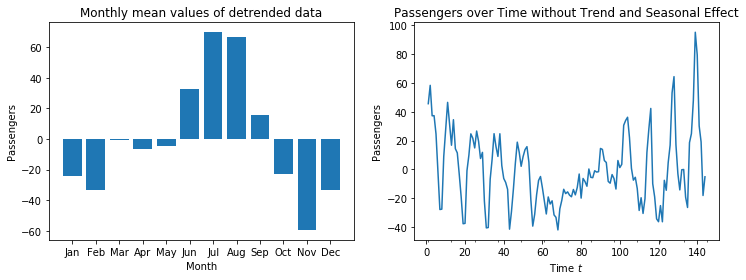

In [9]:
monthly_means = air_passengers_detrended.groupby(air_passengers_detrended.index.month).mean()

air_passengers_detrended_unseasonal = air_passengers_detrended - np.tile(monthly_means,12)

f, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].set_title('Monthly mean values of detrended data')
axes[0].bar(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], monthly_means)
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Passengers')

axes[1].set_title('Passengers over Time without Trend and Seasonal Effect')
axes[1].plot(X, air_passengers_detrended_unseasonal)
axes[1].set_xlabel('Time $t$')
axes[1].set_xticks(np.arange(0,13)*12+1, ('1949','','1951','','1953','','1955','','1957','','1959','','1961'))
axes[1].set_ylabel('Passengers')
plt.show()

### Differencing

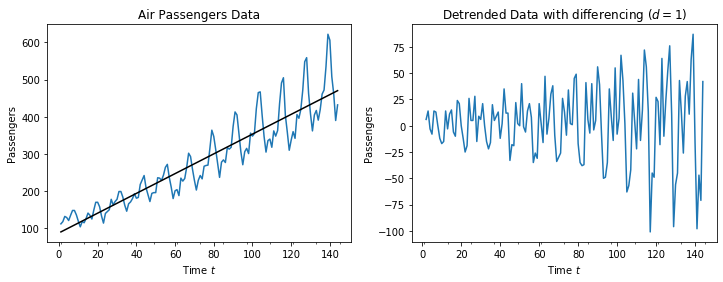

In [17]:
air_passengers_differenced = air_passengers_df.diff(1)

f, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].set_title('Air Passengers Data' % regr.coef_[0])
axes[0].plot(X, Y)
axes[0].plot(X, T_pred, color='black')
axes[0].set_xlabel('Time $t$')
axes[0].set_xticks(np.arange(0,13)*12+1, ('1949','','1951','','1953','','1955','','1957','','1959','','1961'))
axes[0].set_ylabel('Passengers')

axes[1].set_title('Detrended Data with differencing ($d=1$)')
axes[1].plot(X, air_passengers_differenced)
axes[1].set_xlabel('Time $t$')
axes[1].set_xticks(np.arange(0,13)*12+1, ('1949','','1951','','1953','','1955','','1957','','1959','','1961'))
axes[1].set_ylabel('Passengers')
plt.show()

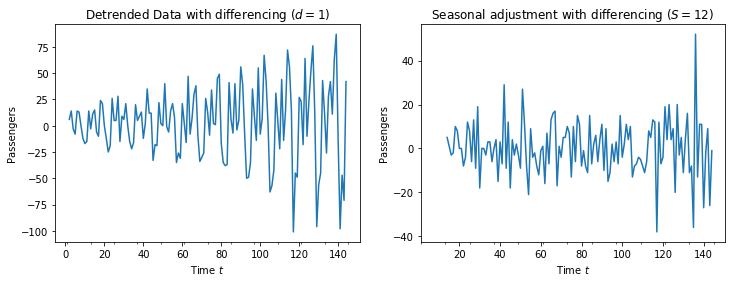

In [18]:
air_passengers_differenced_seasonal = air_passengers_differenced.diff(periods=12)

f, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].set_title('Detrended Data with differencing ($d=1$)')
axes[0].plot(X, air_passengers_differenced)
axes[0].set_xlabel('Time $t$')
axes[0].set_xticks(np.arange(0,13)*12+1, ('1949','','1951','','1953','','1955','','1957','','1959','','1961'))
axes[0].set_ylabel('Passengers')

axes[1].set_title('Seasonal adjustment with differencing ($S=12$)')
axes[1].plot(X, air_passengers_differenced_seasonal)
axes[1].set_xlabel('Time $t$')
axes[1].set_xticks(np.arange(0,13)*12+1, ('1949','','1951','','1953','','1955','','1957','','1959','','1961'))
axes[1].set_ylabel('Passengers')
plt.show()

## Autocorrelation with ARMA

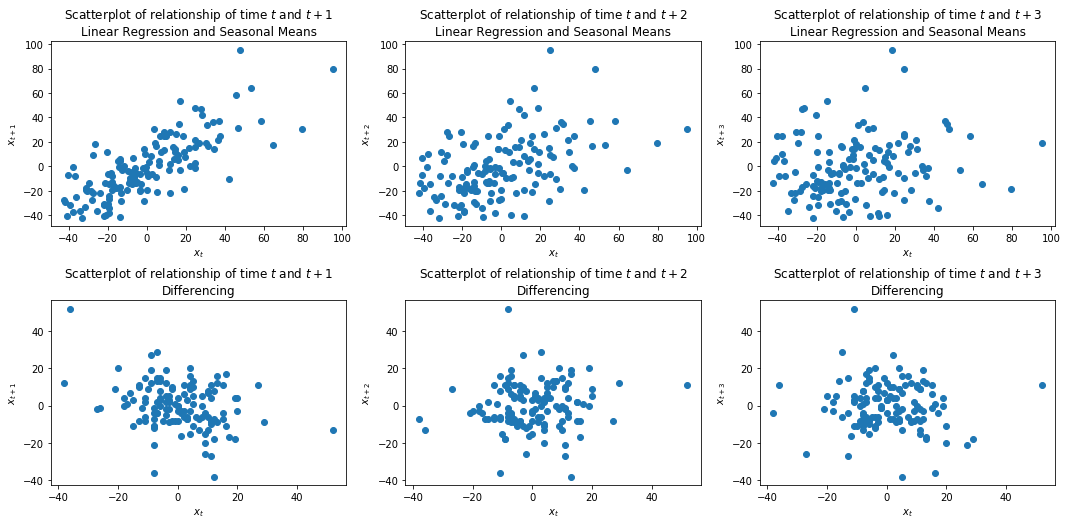

In [33]:
from pandas.plotting import lag_plot

fig, axes = plt.subplots(2, 3, figsize=(18, 7))

for i in range(1,4):
    axes[0,i-1].set_title('Scatterplot of relationship of time $t$ and $t+%i$\nLinear Regression and Seasonal Means'%i)
    lag_plot(air_passengers_detrended_unseasonal,lag=i, ax=axes[0,i-1])
    axes[0,i-1].set_xlabel('$x_t$')
    axes[0,i-1].set_ylabel('$x_{t+%i}$'%i)
    
    axes[1,i-1].set_title('Scatterplot of relationship of time $t$ and $t+%i$\nDifferencing'%i)
    lag_plot(air_passengers_differenced_seasonal,lag=i, ax=axes[1,i-1])
    axes[1,i-1].set_xlabel('$x_t$')
    axes[1,i-1].set_ylabel('$x_{t+%i}$'%i)

plt.subplots_adjust(left=None, bottom=0, right=None,
                top=None, wspace=None, hspace=0.4)
plt.show()

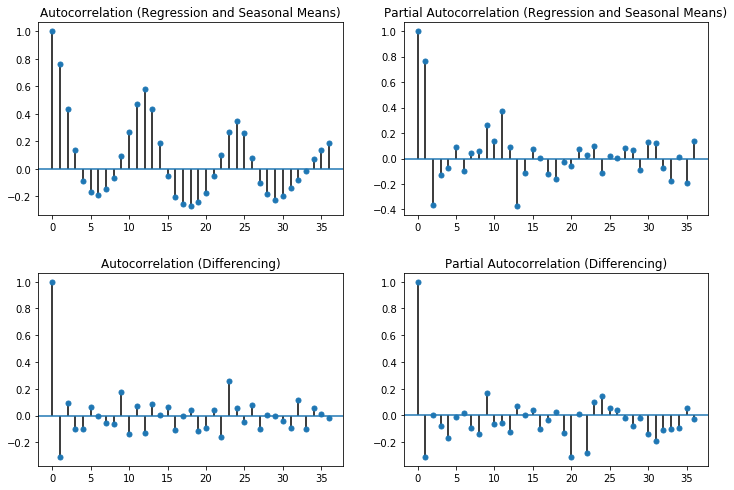

In [44]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(2, 2, figsize=(12, 7))

plot_acf(air_passengers_detrended_unseasonal, lags=36, alpha=None, ax=axes[0,0], title="Autocorrelation (Regression and Seasonal Means)")
plot_pacf(air_passengers_detrended_unseasonal, lags=36, alpha=None, ax=axes[0,1], title="Partial Autocorrelation (Regression and Seasonal Means)")
plot_acf(air_passengers_differenced_seasonal.dropna(), lags=36, alpha=None, ax=axes[1,0], title="Autocorrelation (Differencing)")
plot_pacf(air_passengers_differenced_seasonal.dropna(), lags=36, alpha=None, ax=axes[1,1], title="Partial Autocorrelation (Differencing)")
plt.subplots_adjust(left=None, bottom=0, right=None,
                top=None, wspace=None, hspace=0.3)
plt.show()